In [11]:
import csv
import pandas as pd
from scipy.stats import pearsonr
import os.path
import matplotlib.pyplot as plt
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm
encoding='iso-8859-1'
figure_folder = "figures/"

In [12]:
all_projects = ['eclipse.platform', 'guava', 'guice', 'hadoop', 'spark', 'flow' ]
datas = {}
for project in all_projects:
    print( "project: ", project)
    df = pd.read_csv(project+"/data.csv")
    datas[project] = df


project:  eclipse.platform
project:  guava
project:  guice
project:  hadoop
project:  spark
project:  flow


In [13]:
def generate_histograms(col):
    project_correlations = {}
    fig, axes = plt.subplots(nrows=2, ncols=3, dpi=1200)
    i = 0
    for project in all_projects:
        print("\t"+project)
        df = datas[project]
        comments = df[col]
        mx = comments.max()+1 if comments.max()+1 >= len(pd.unique(comments)) else len(pd.unique(comments))
        comments.plot.hist(bins=mx,ax=axes[i//3,i%3])
        axes[i//3,i%3].set_title(project)
        i += 1
    fig.tight_layout()
    fig.savefig(figure_folder+"Distribution_"+col+".png")

In [14]:
def intersection(a,b):
    b = b.columns
    return __intersection(a,b)

def __intersection(a,b):
    return list(set(a) & set(b))

comments_types = ("loc",
                  "Number of commentsComment",
                  "Number of line comments",
                  "Number of Block comments",
                  "Number of Javadoc comments",
                  "Number of comments in methode",
                  "Number of method comments",
                  "Number of class comments")

loc
	eclipse.platform
	guava
	guice
	hadoop
	spark
	flow
Number of commentsComment
	eclipse.platform
	guava
	guice
	hadoop
	spark
	flow
Number of line comments
	eclipse.platform
	guava
	guice
	hadoop
	spark
	flow
Number of Block comments
	eclipse.platform
	guava
	guice
	hadoop
	spark
	flow
Number of Javadoc comments
	eclipse.platform
	guava
	guice
	hadoop
	spark
	flow
Number of comments in methode
	eclipse.platform
	guava
	guice
	hadoop
	spark
	flow
Number of method comments
	eclipse.platform
	guava
	guice
	hadoop
	spark
	flow
Number of class comments
	eclipse.platform
	guava
	guice
	hadoop
	spark
	flow


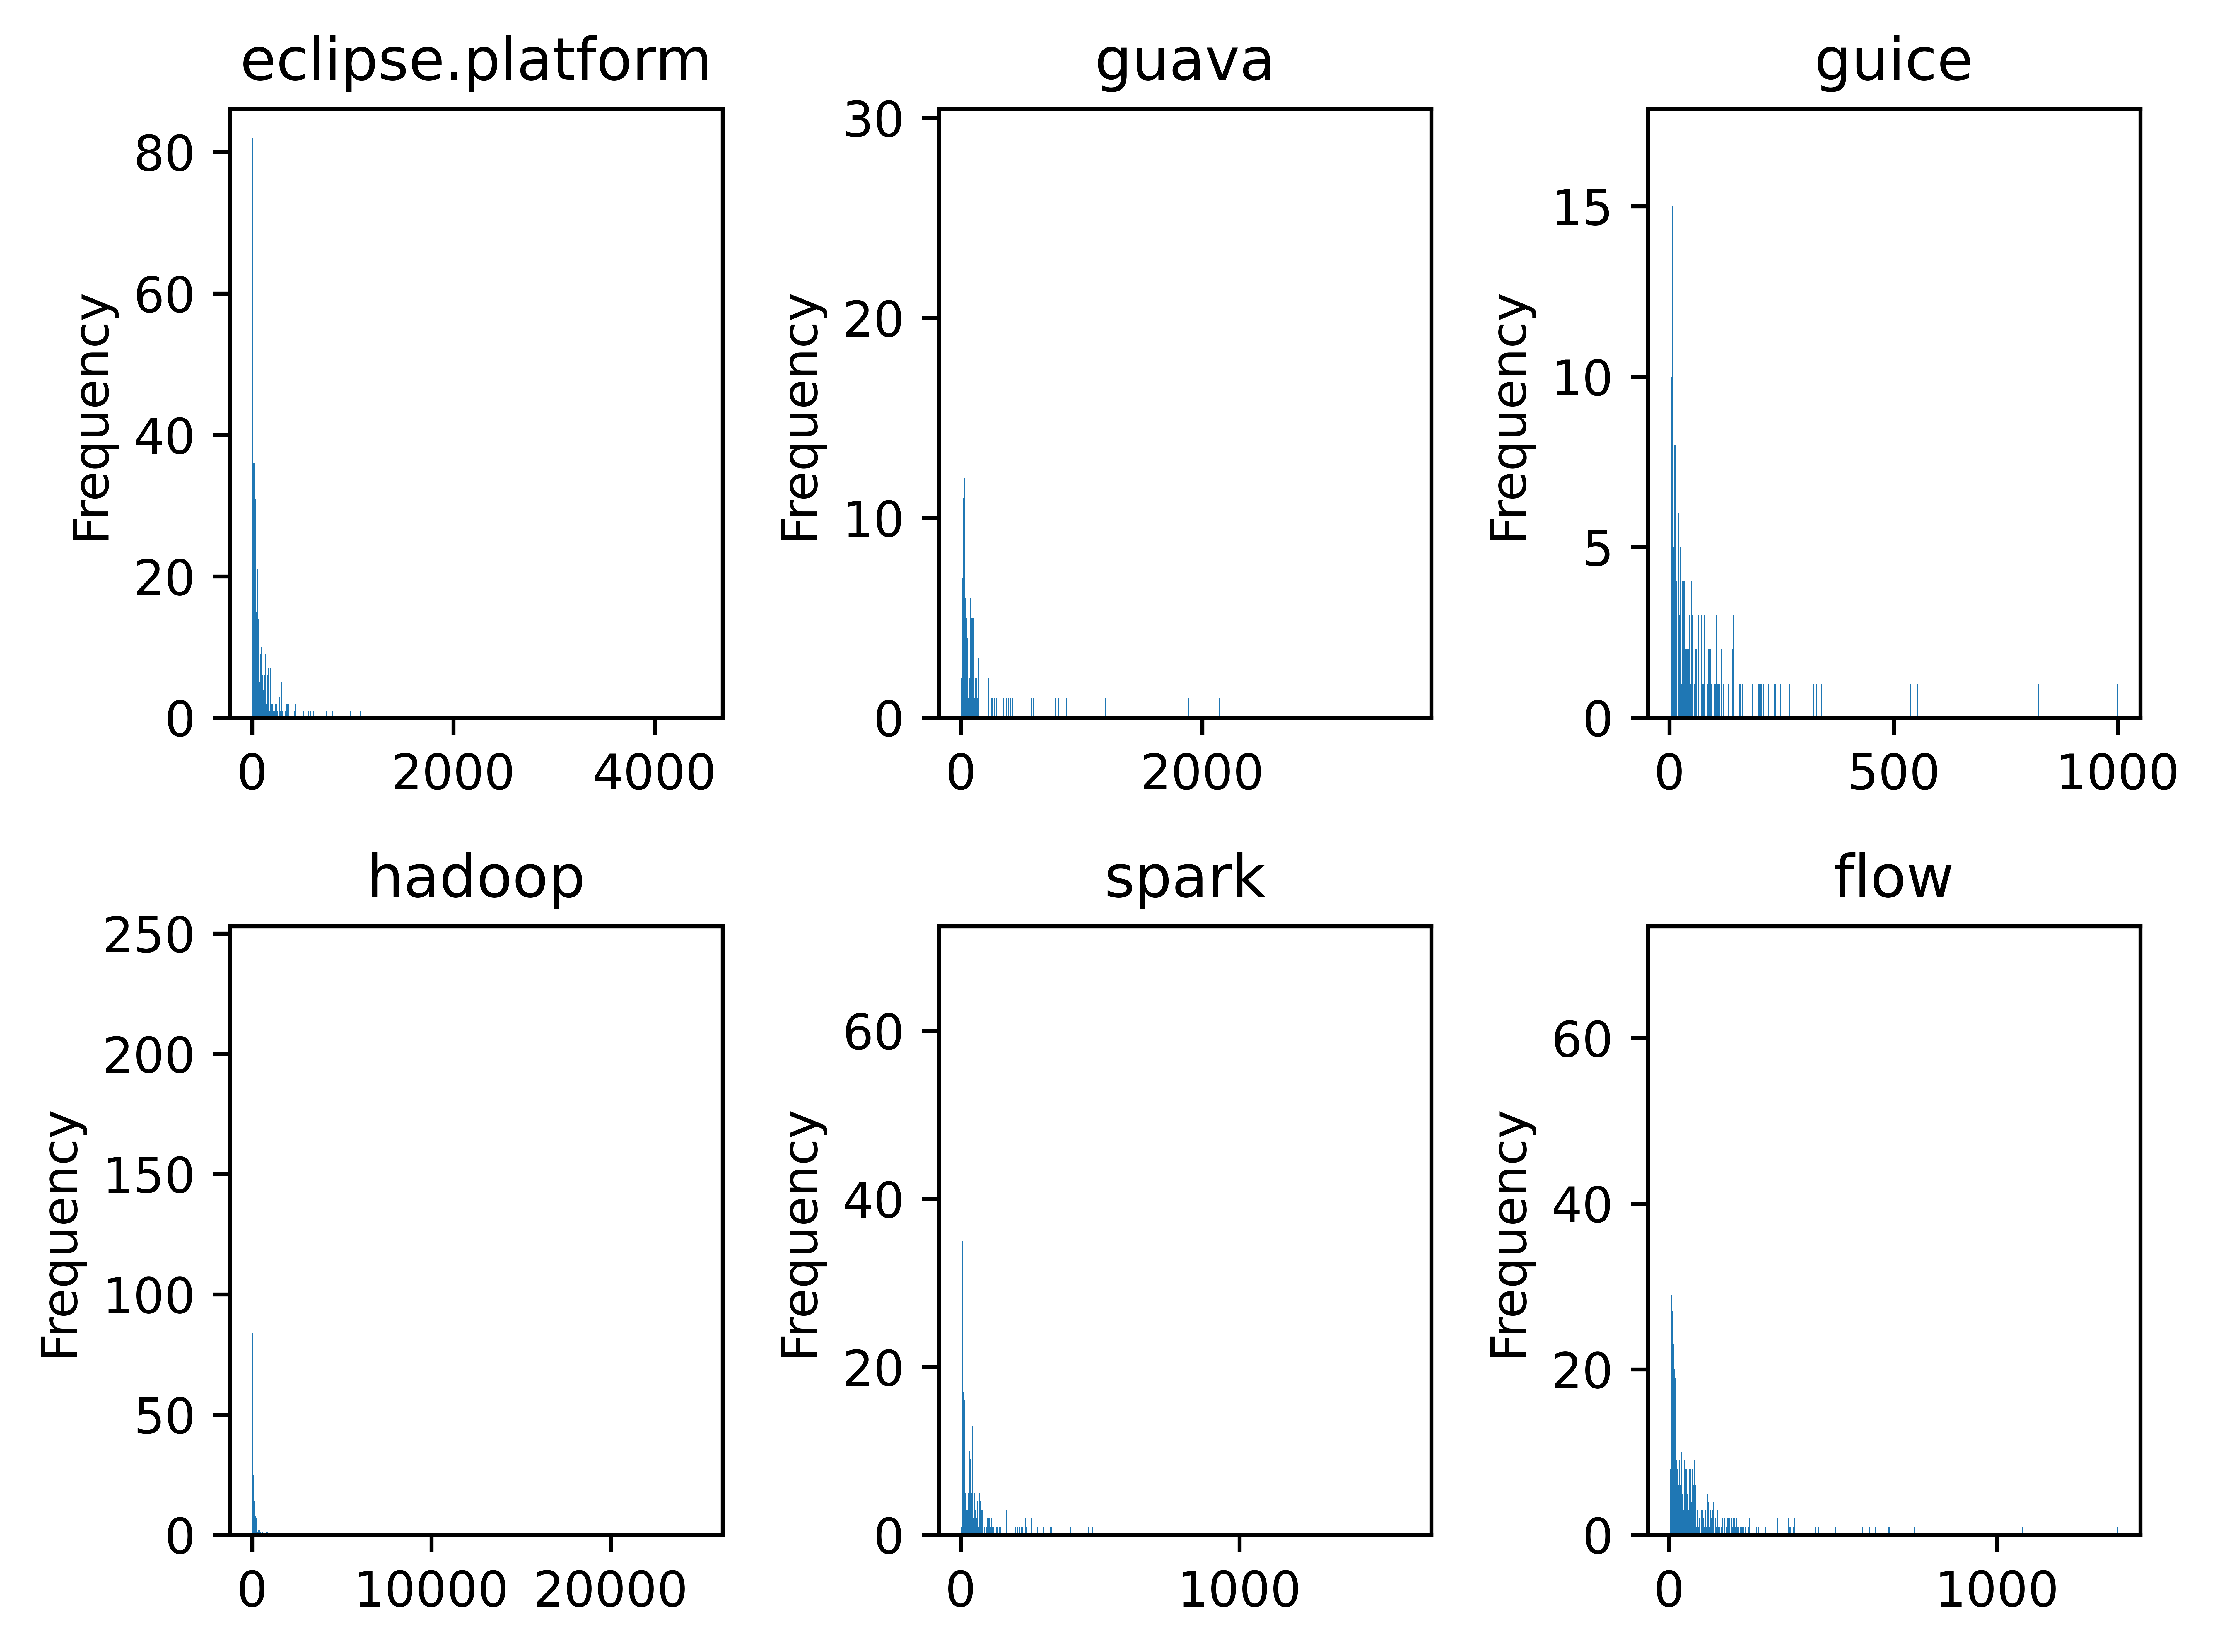

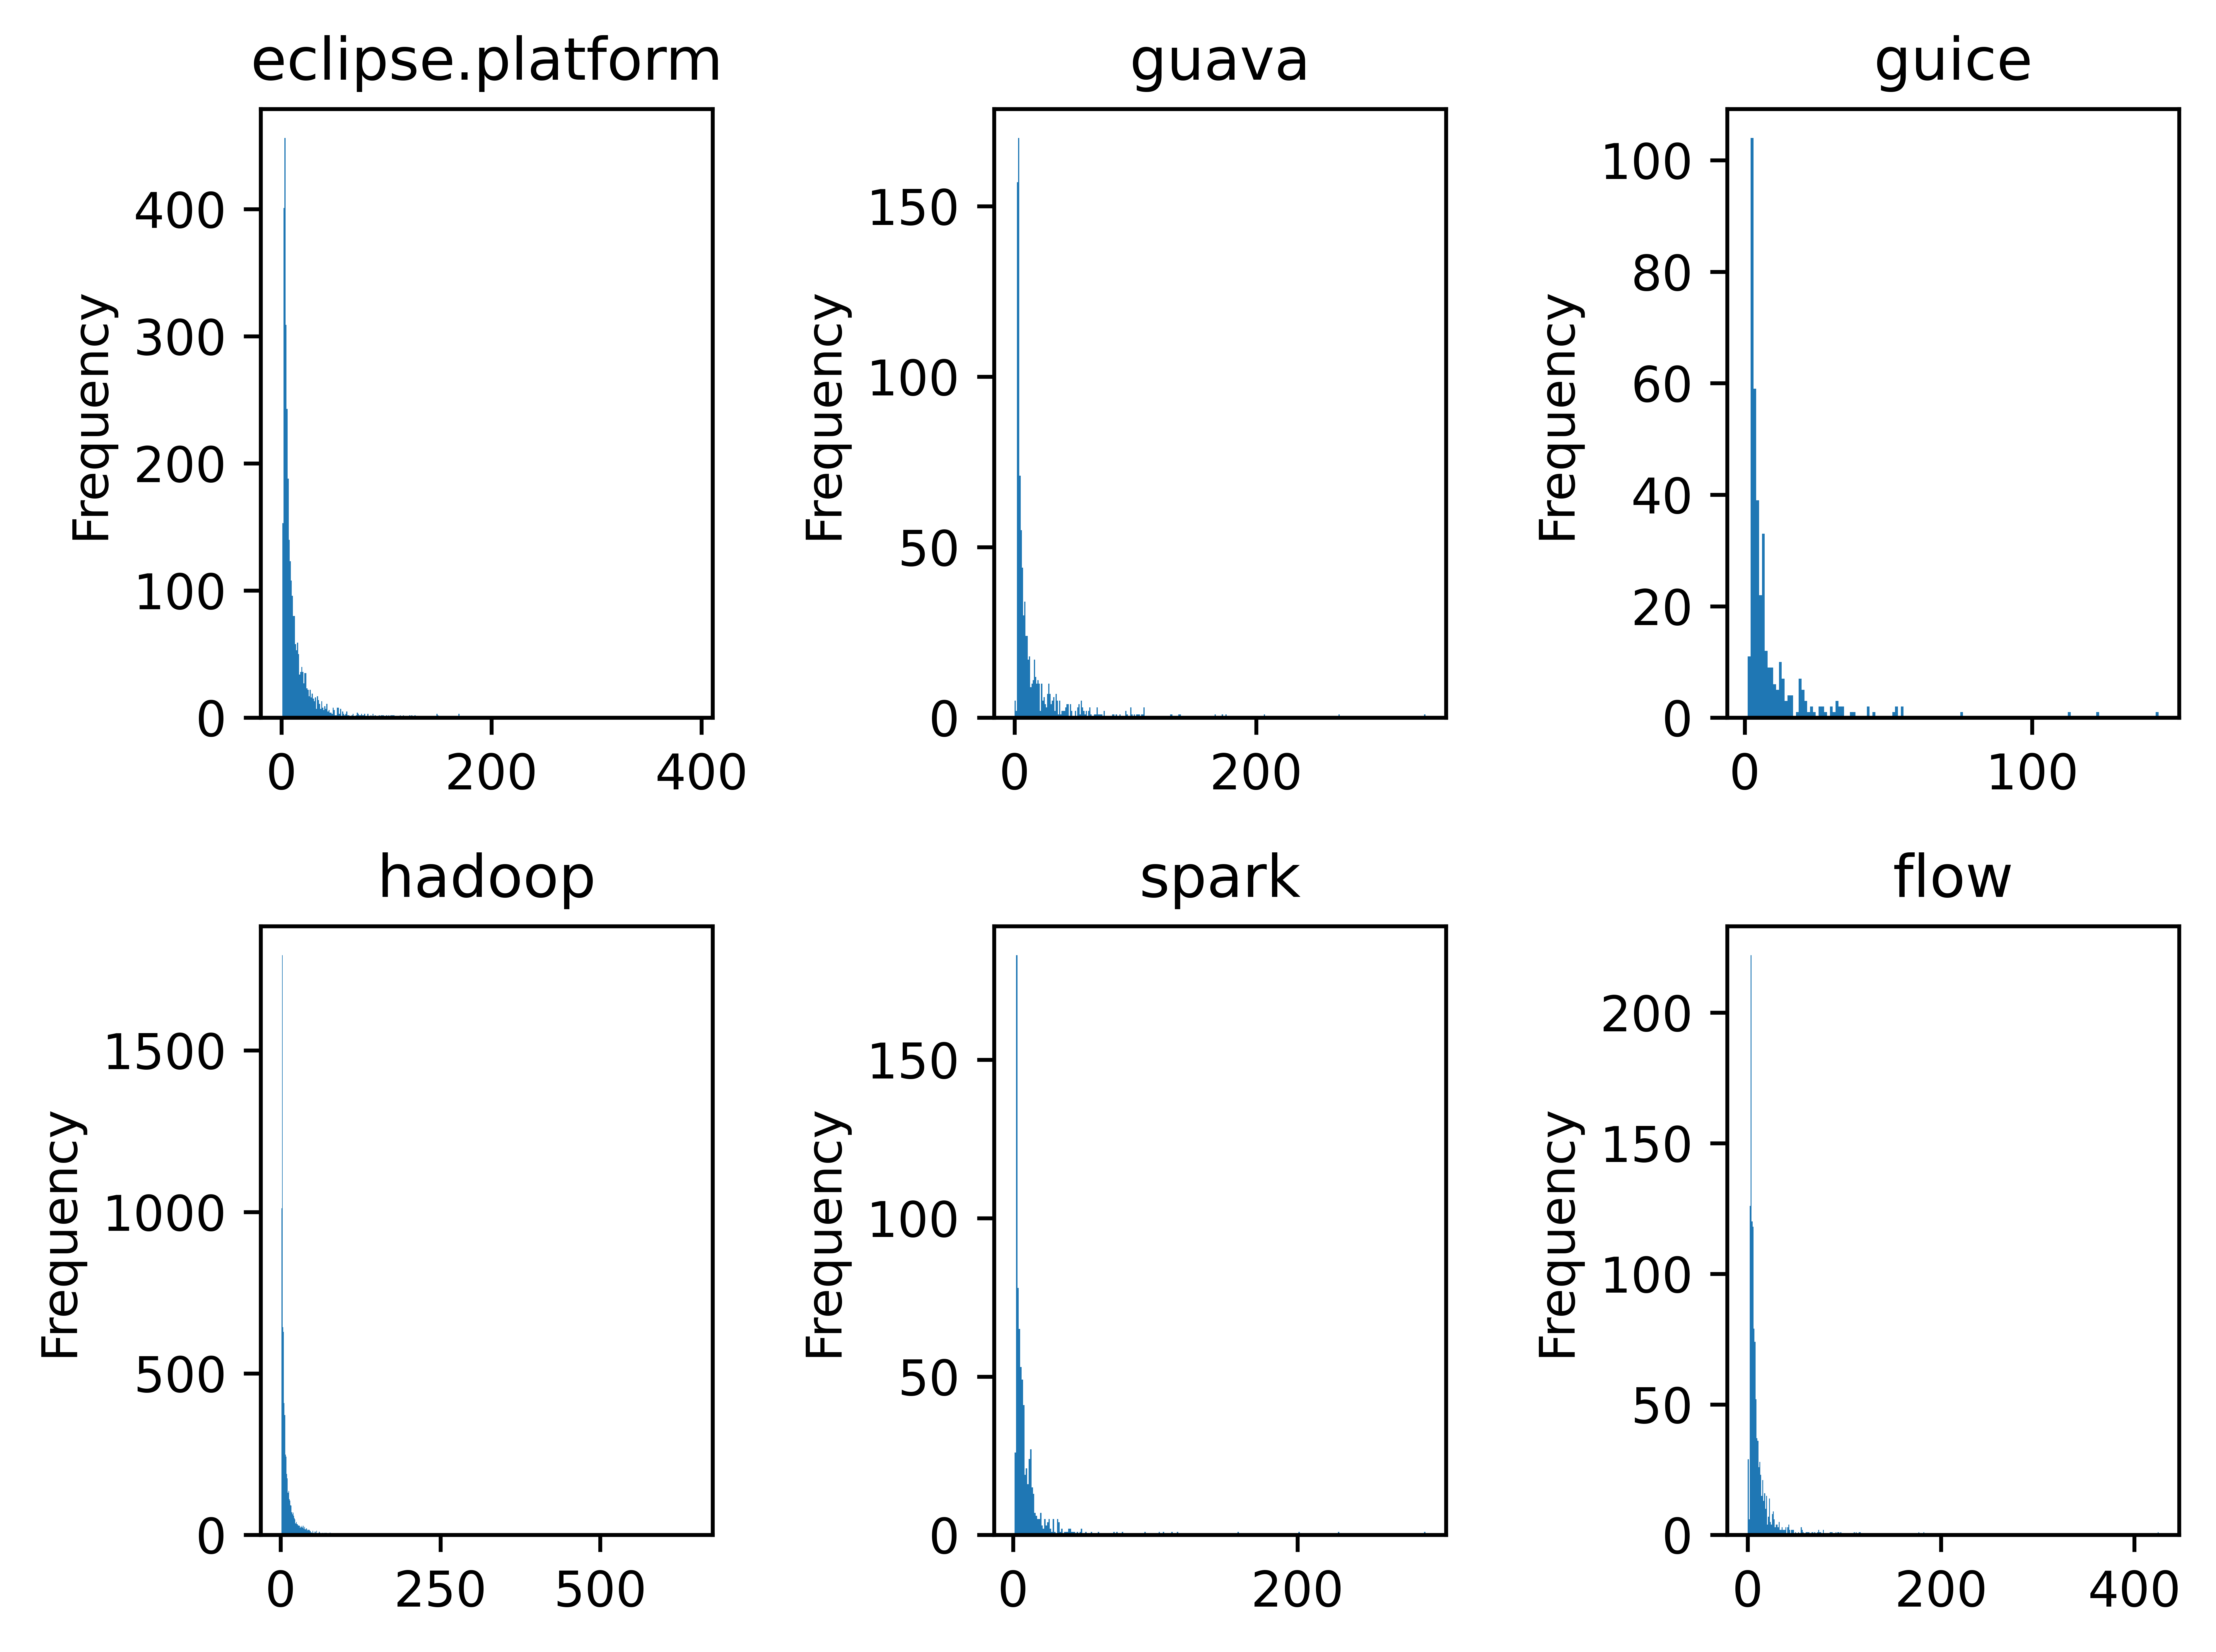

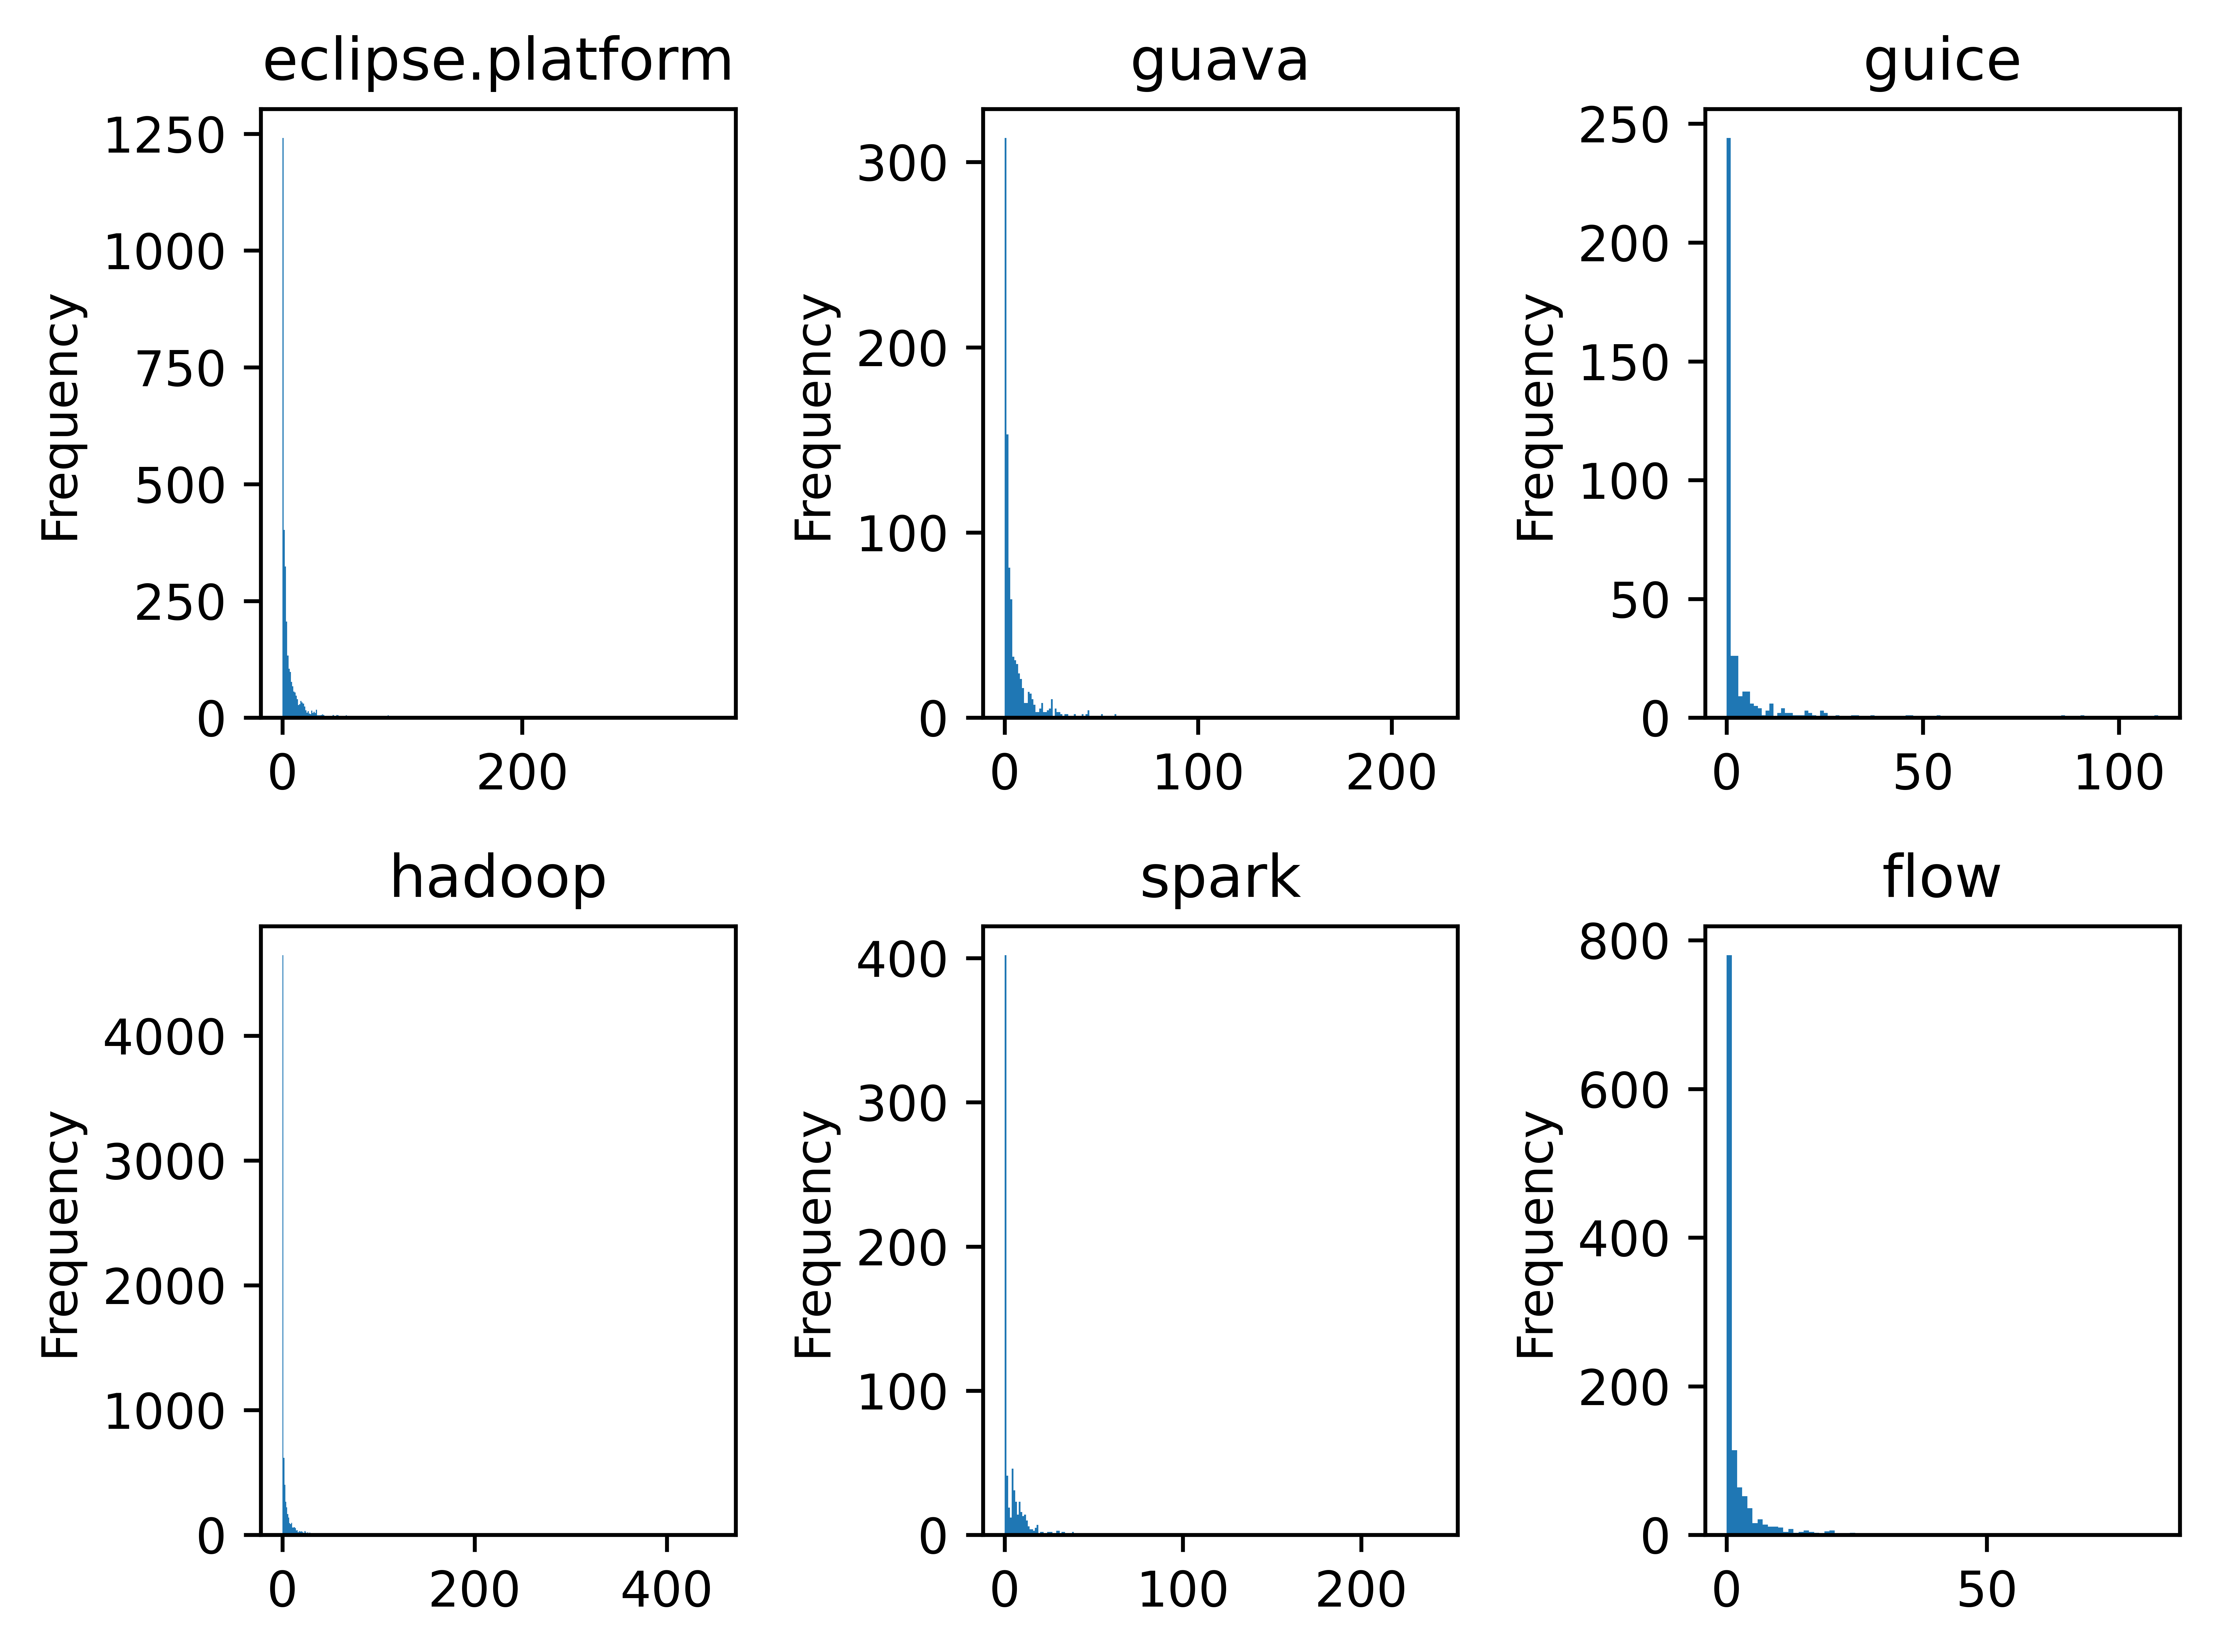

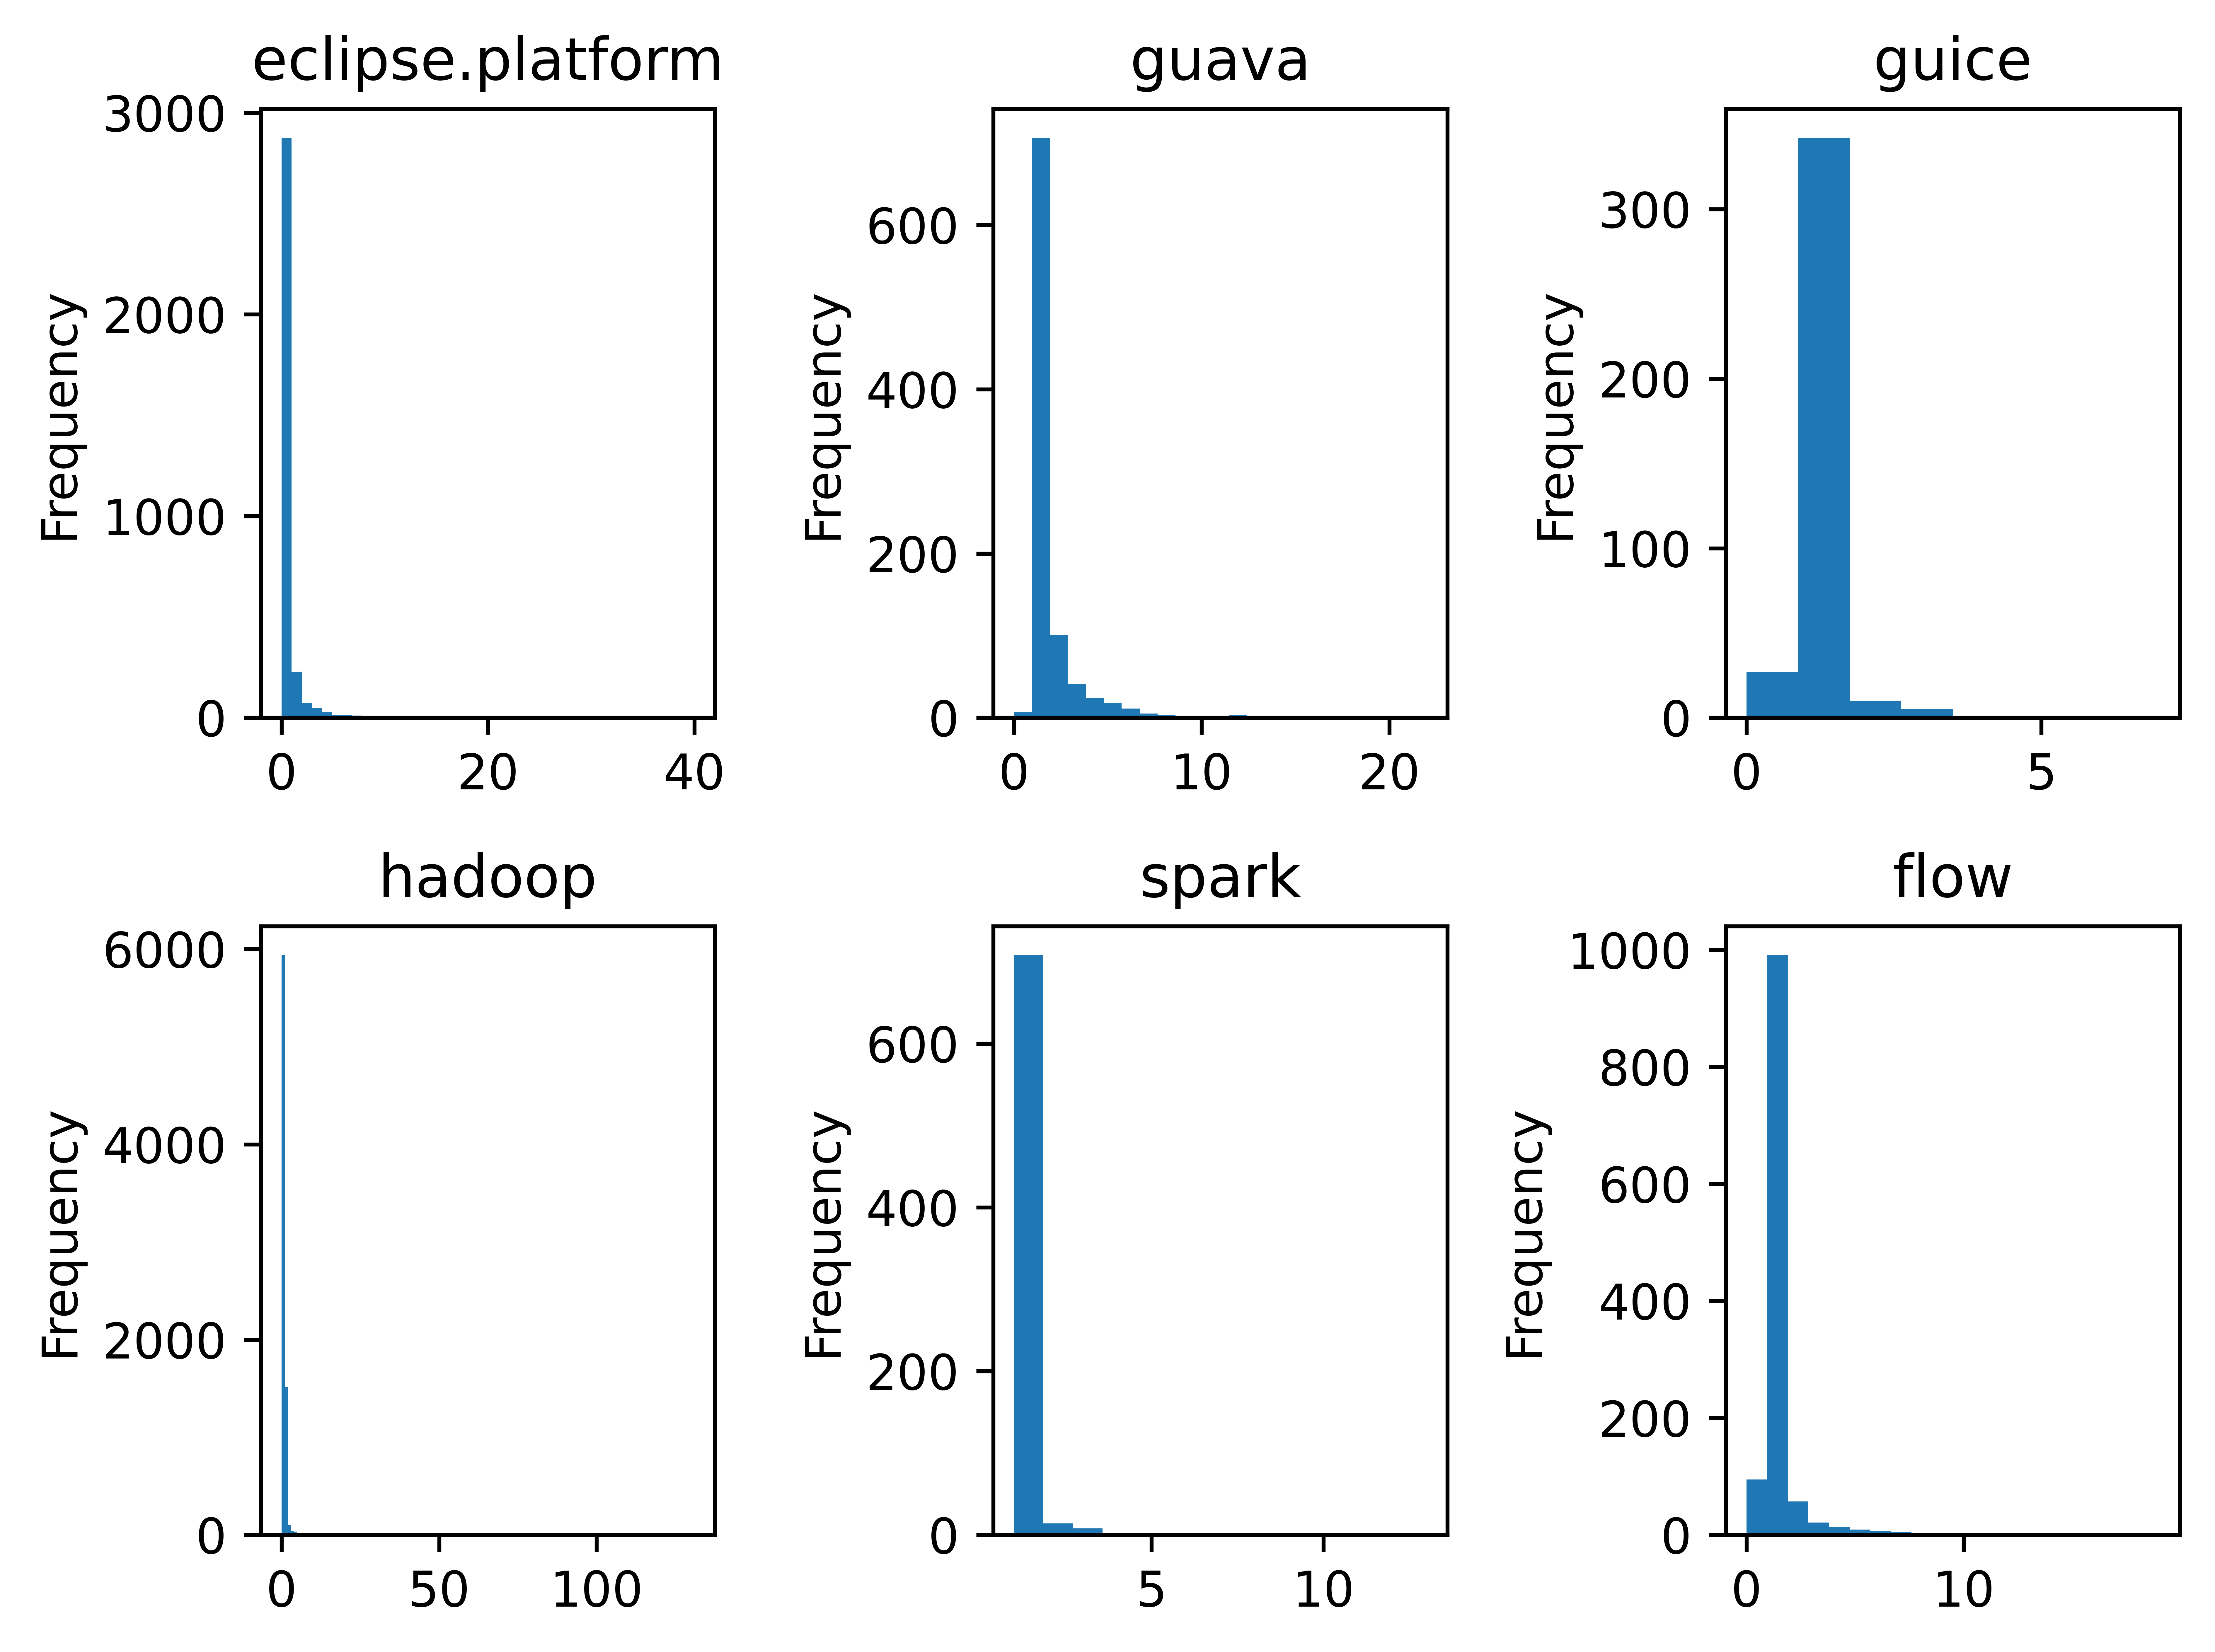

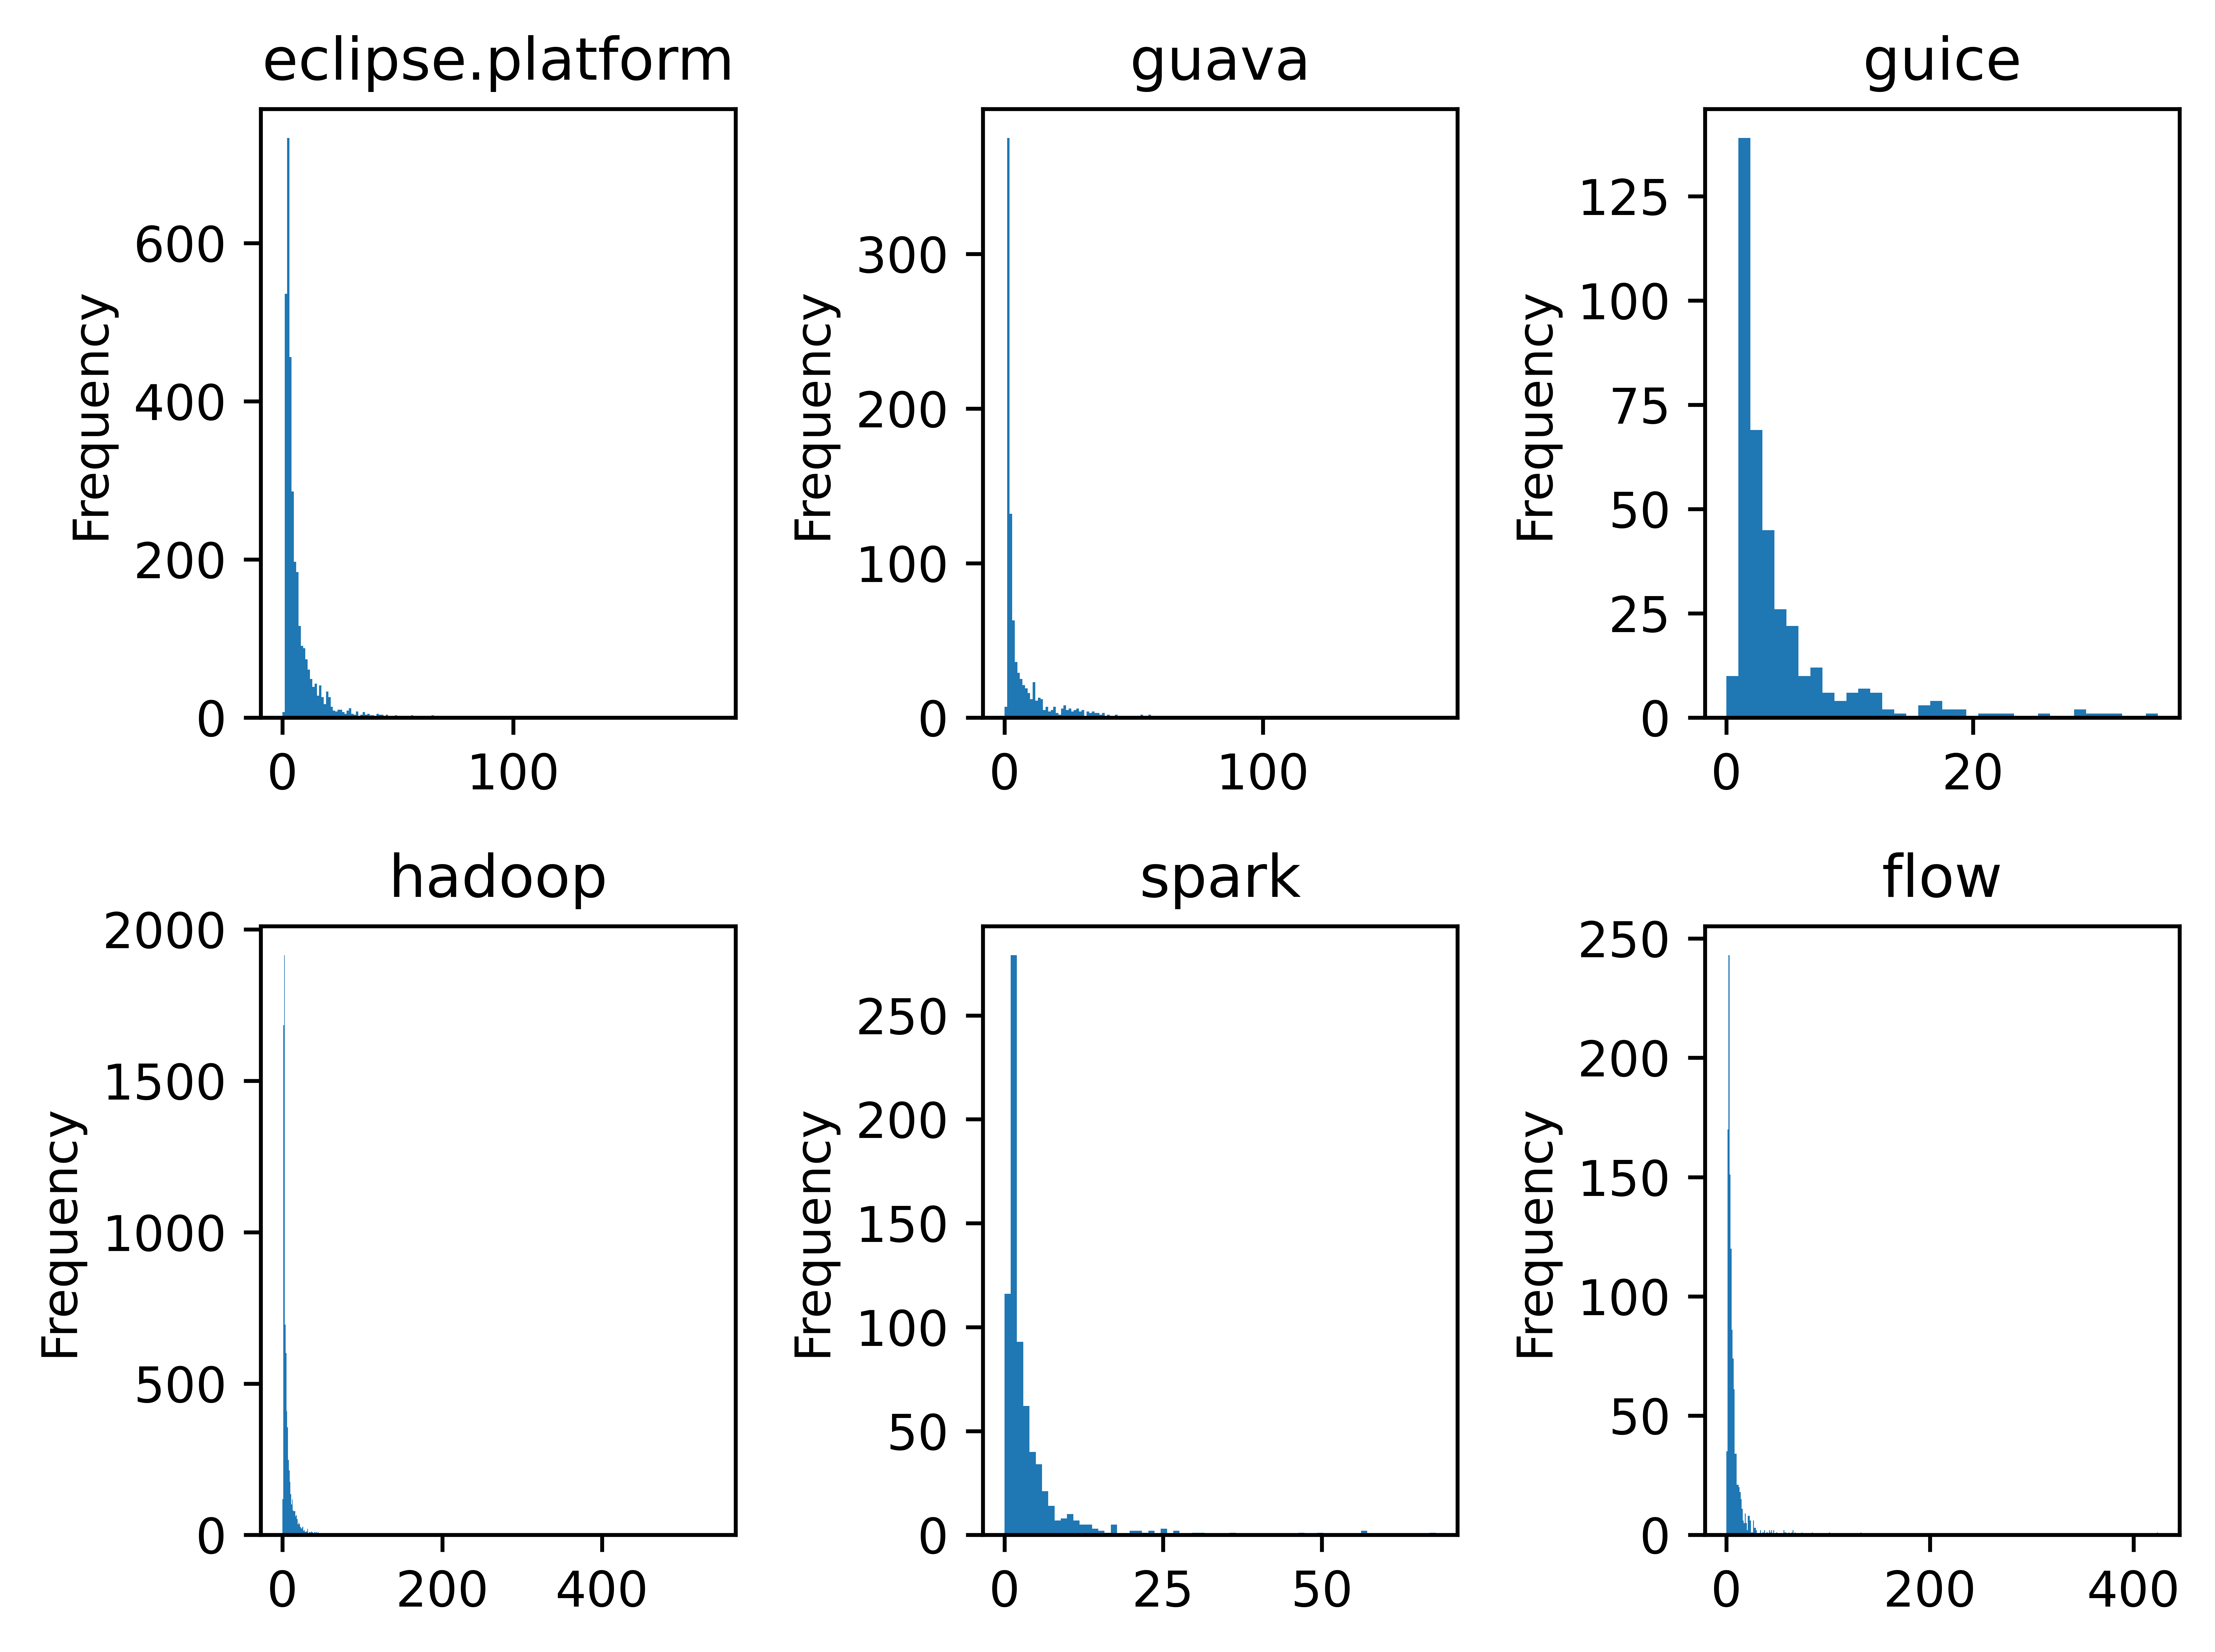

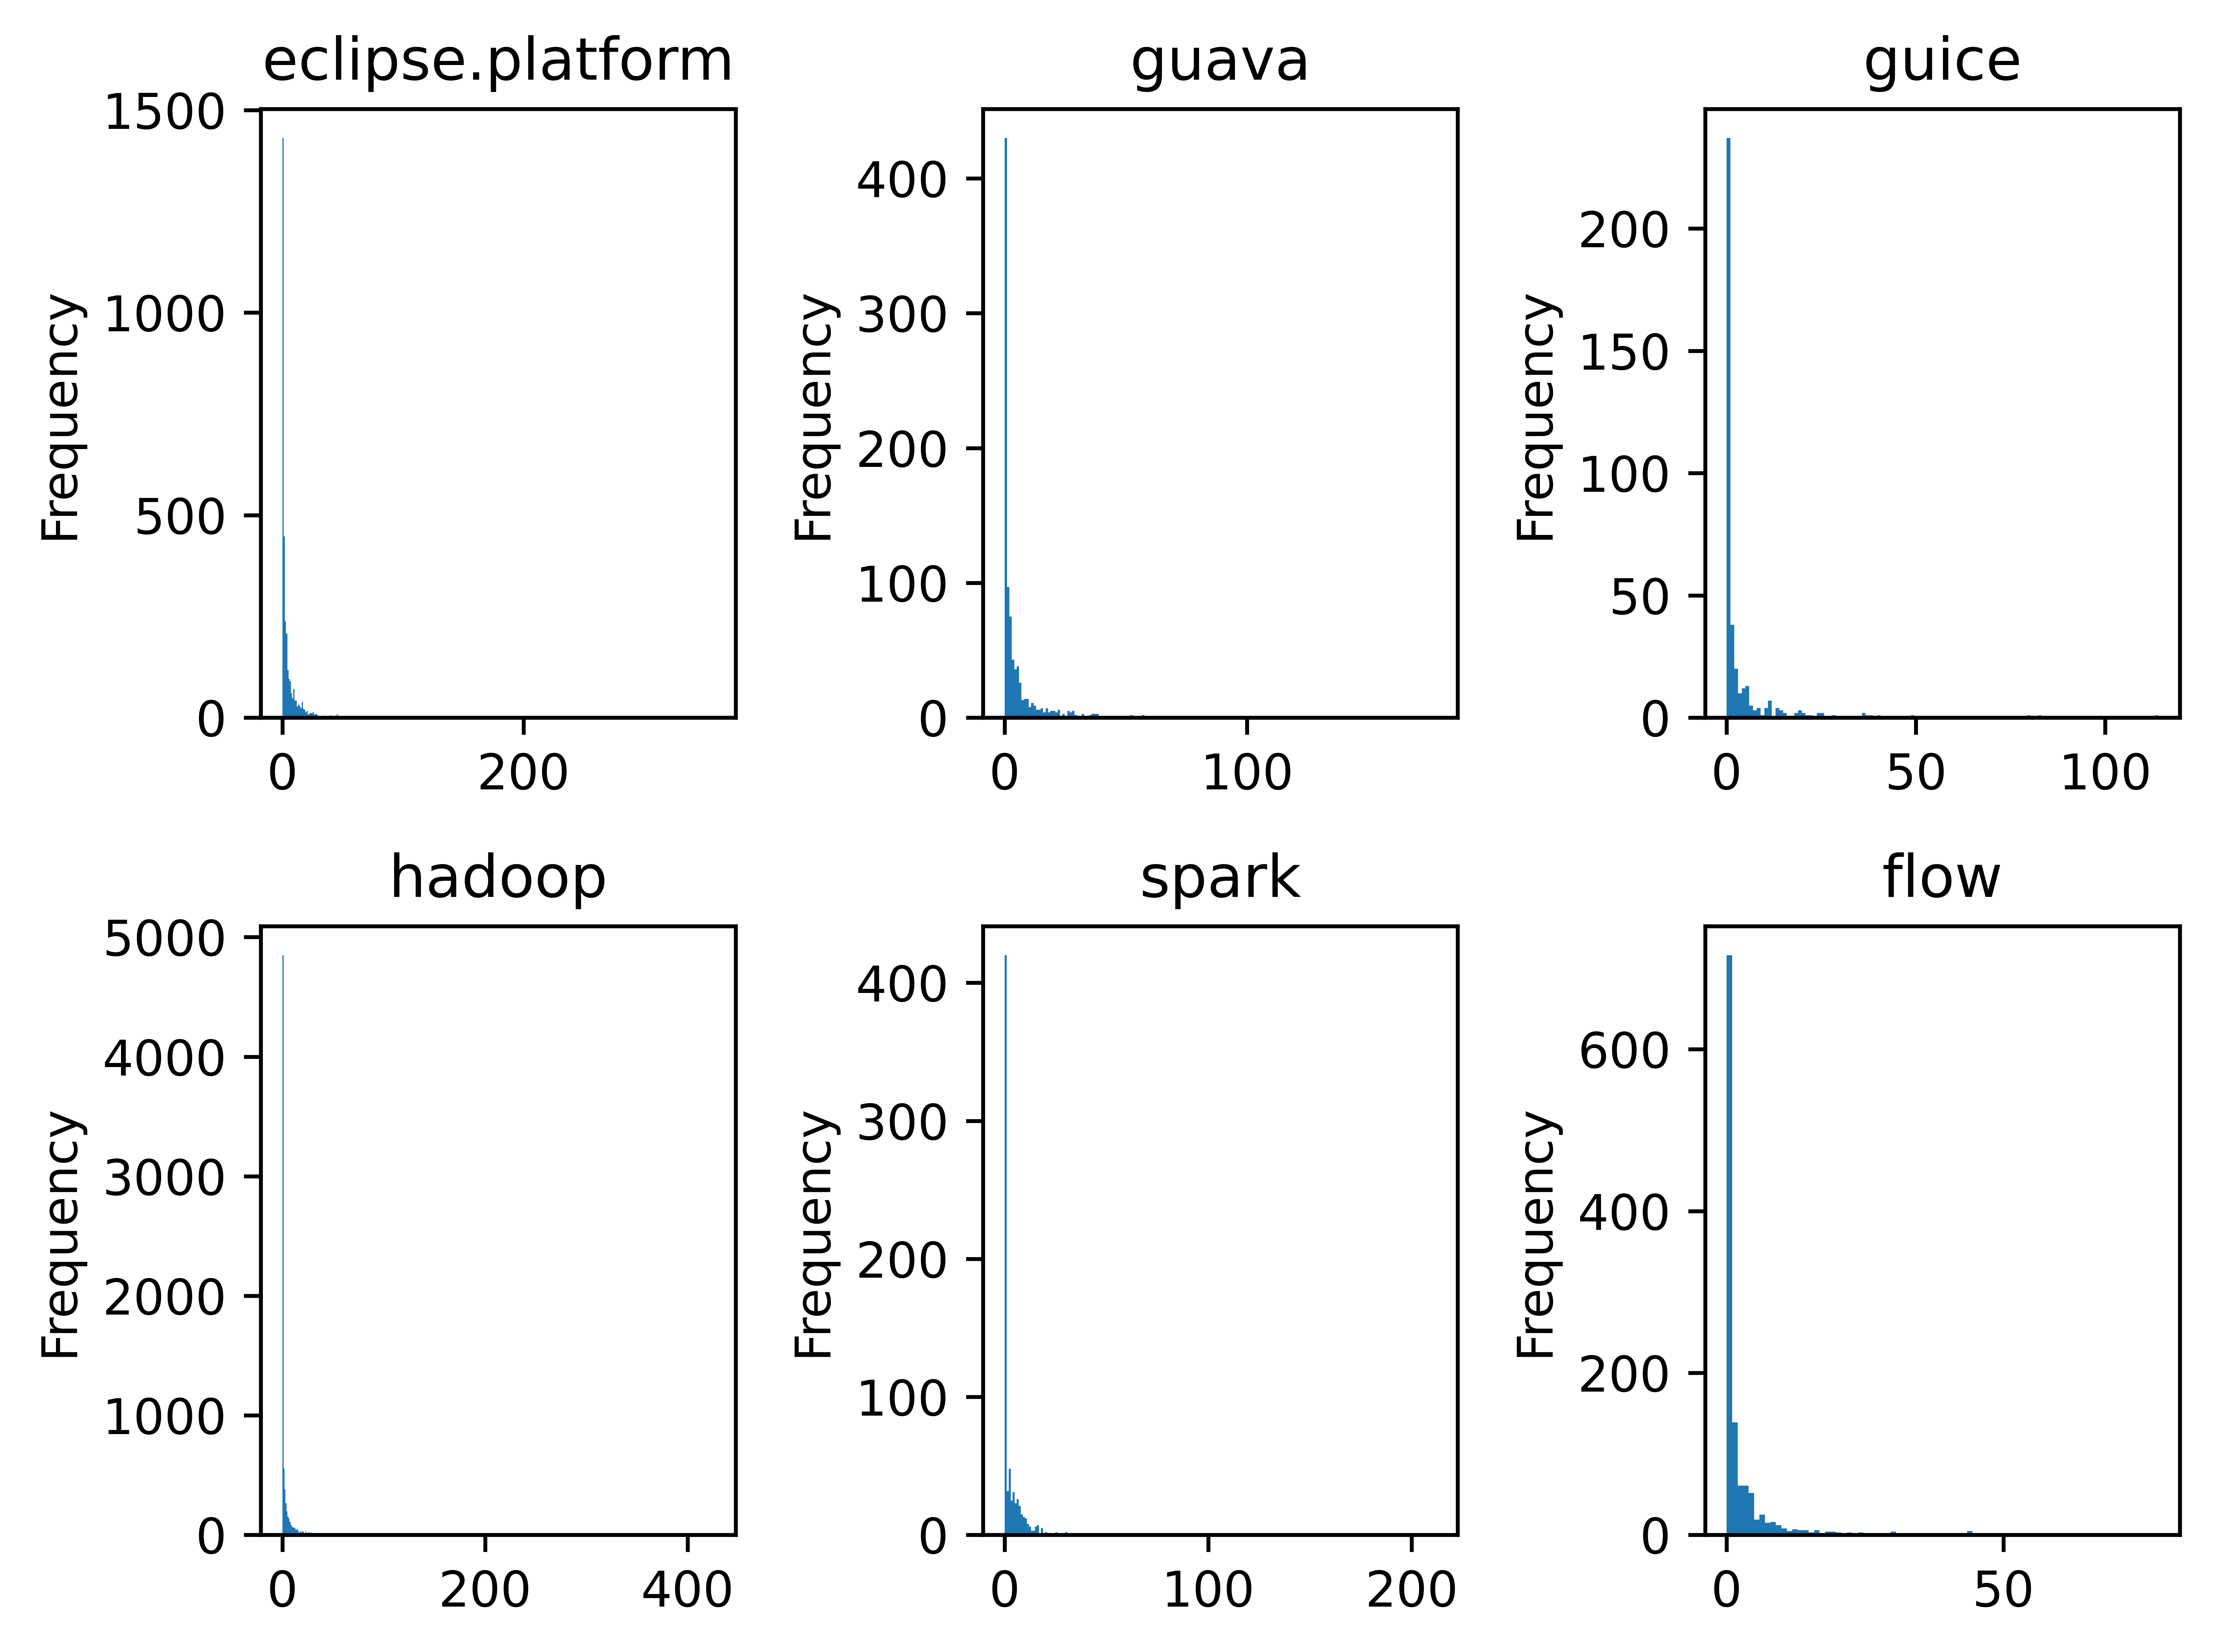

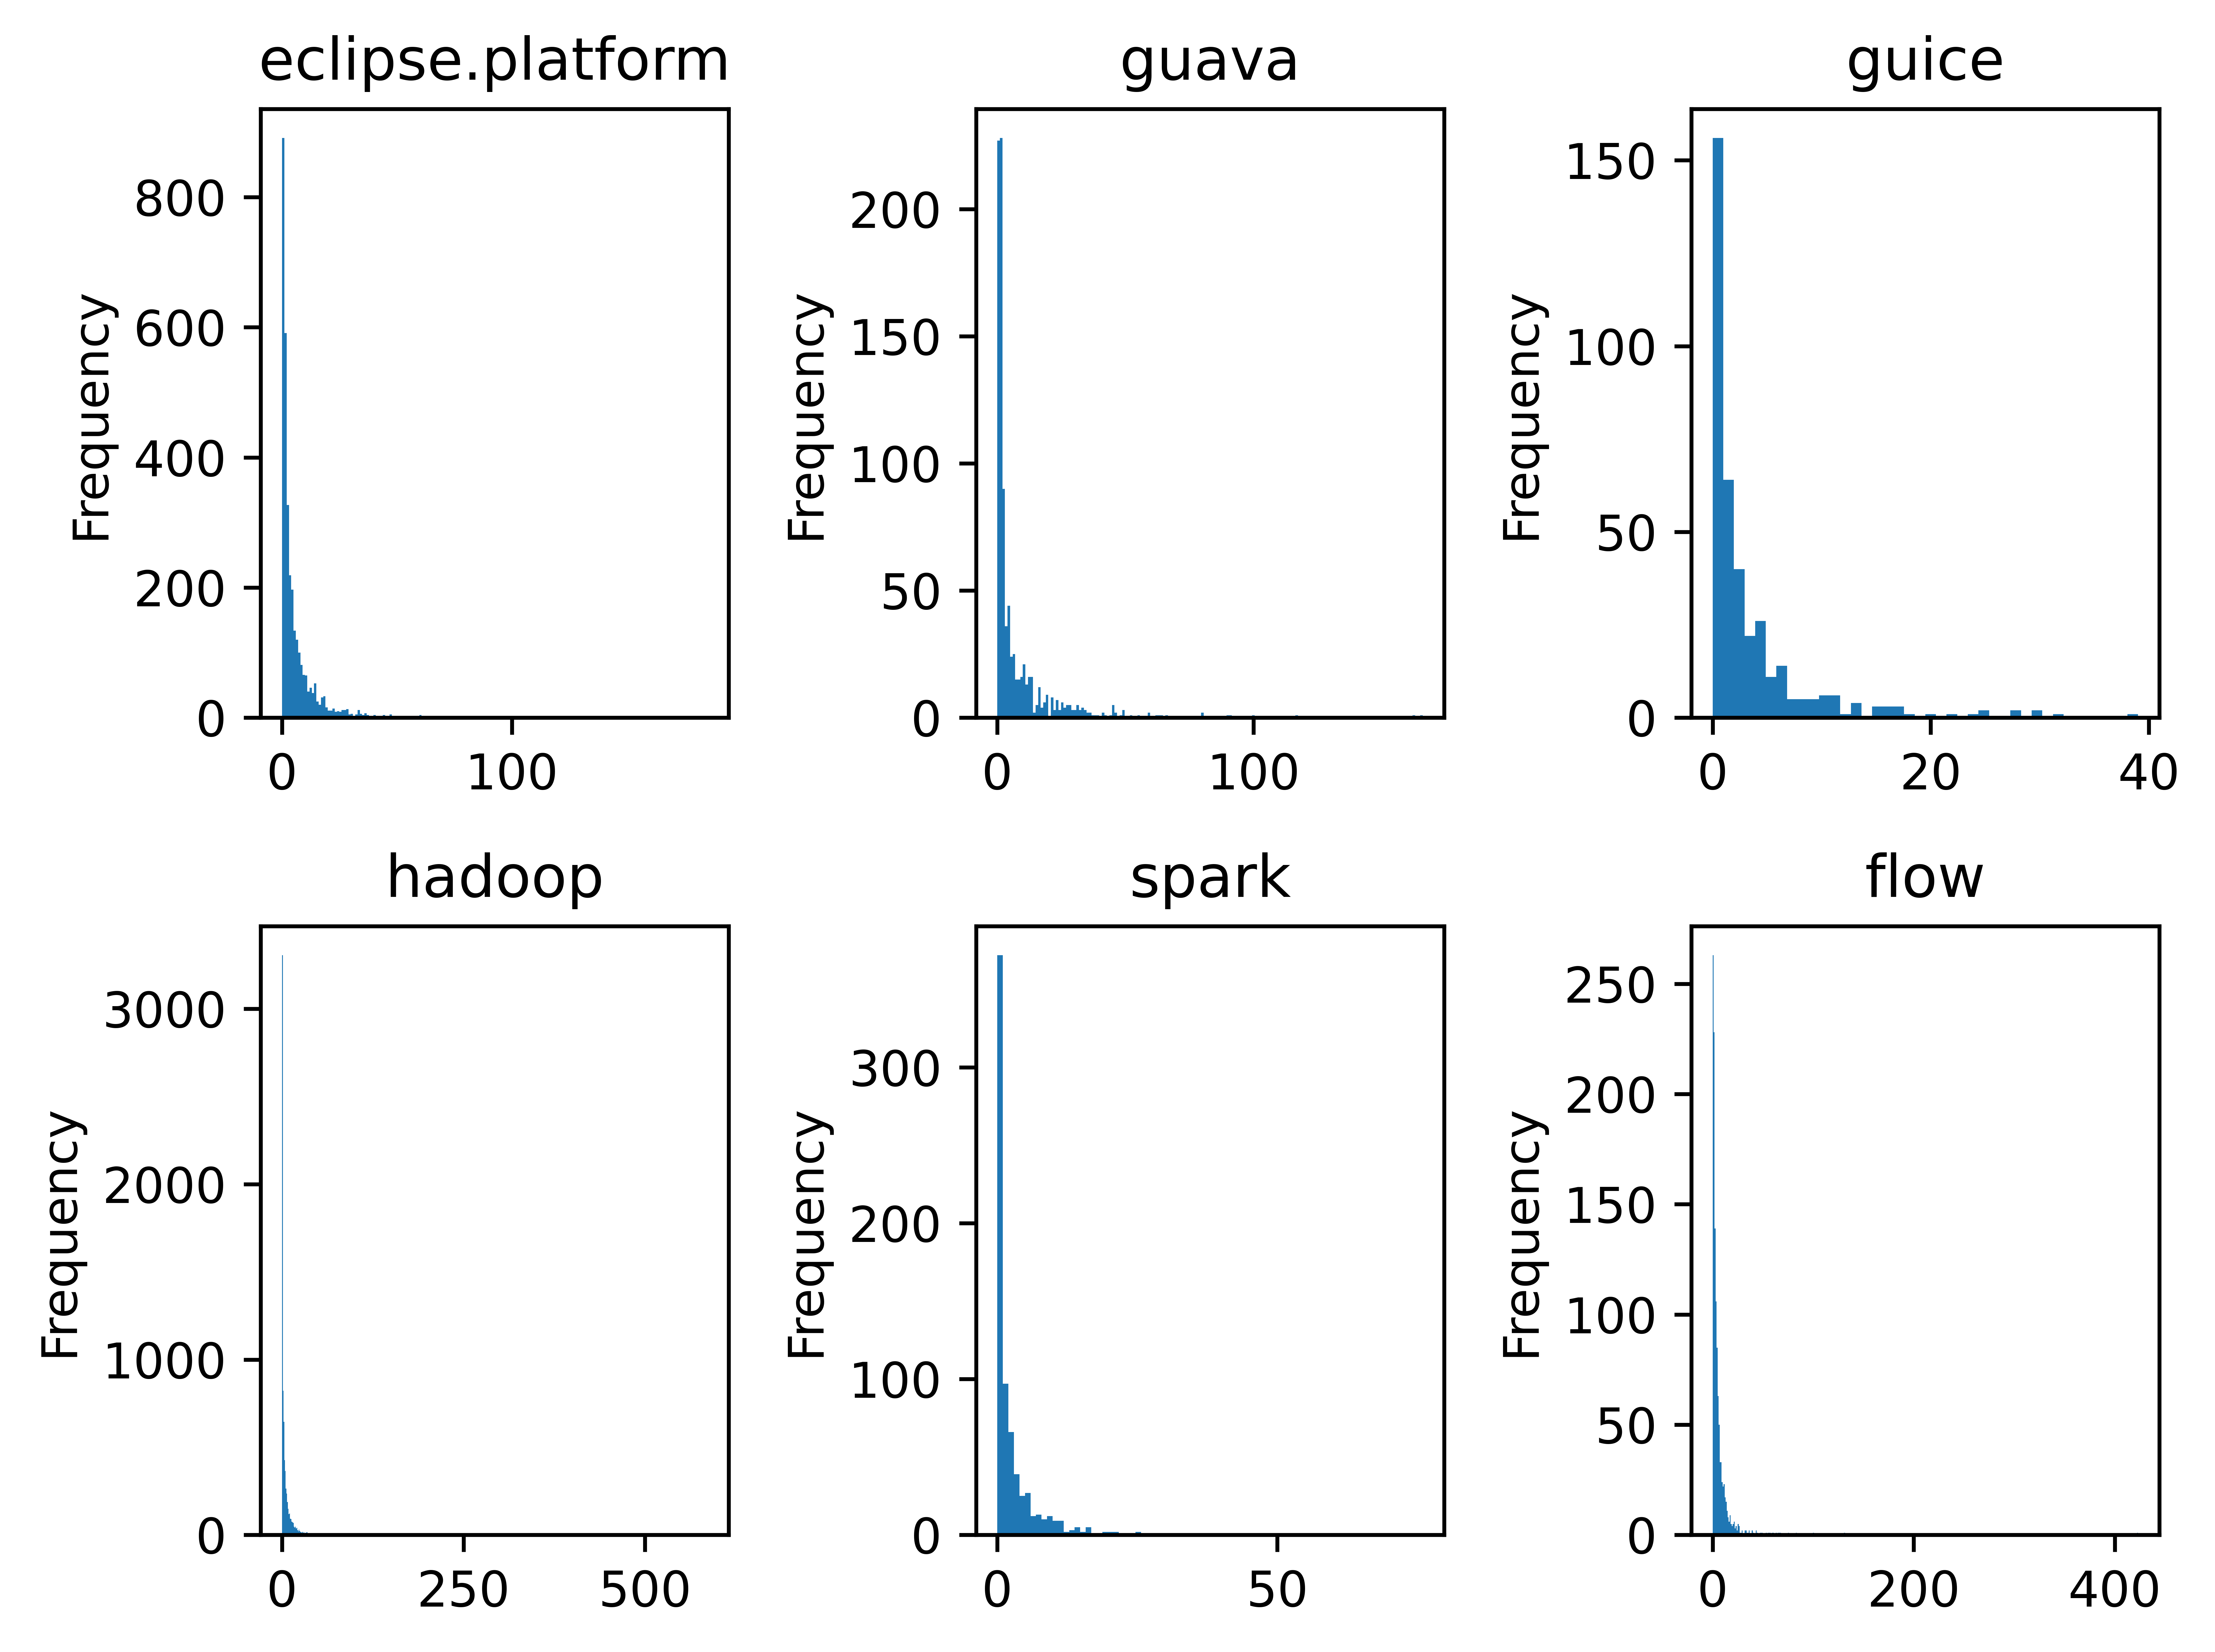

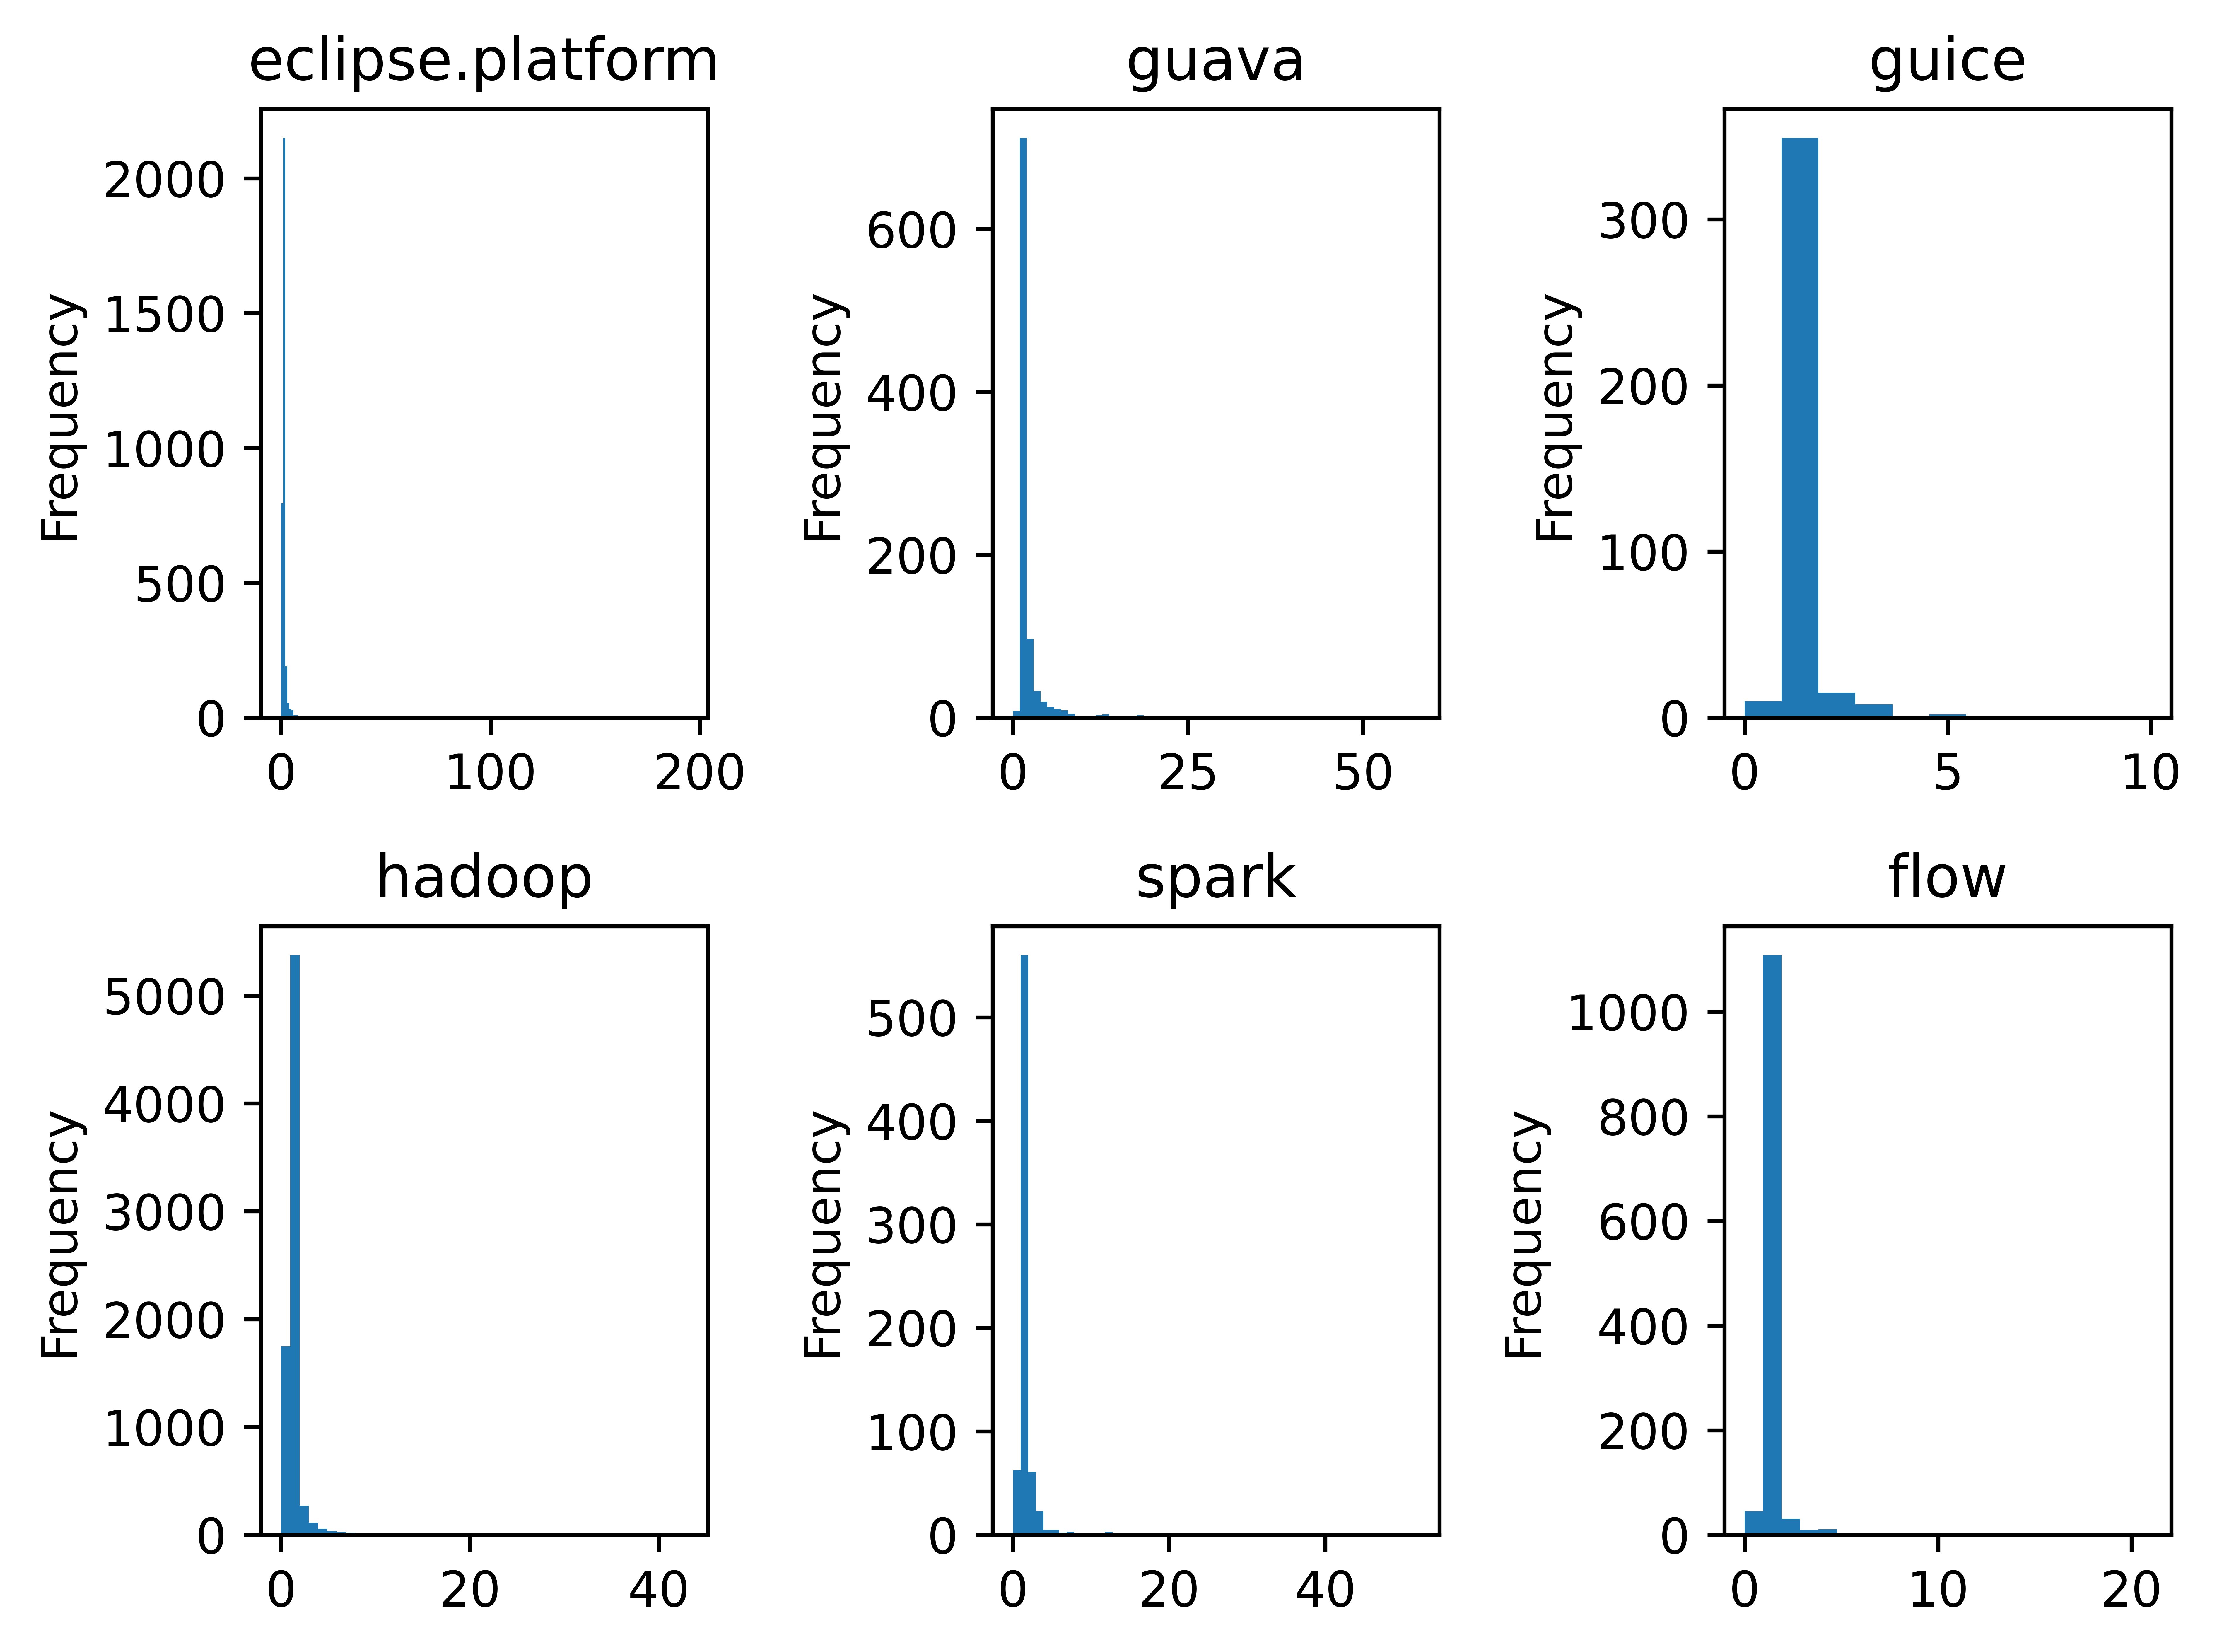

In [9]:


for comment_type in comments_types:
    print(comment_type)
    generate_histograms(comment_type)

In [20]:
rules_pmd = []
rules_sonar = []
rules_sum = ['all_sonar', 'all_pmd', 'all_rulebreaks']

for project in all_projects:
    df = datas[project]
    for column in df:
        if column == "pmd_-":
            df.drop(column, axis=1)
            continue
        if 'pmd' in column and not column in rules_pmd:
            rules_pmd.append(column)
        if 'sonar' in column and not column in rules_sonar:
           rules_sonar.append(column)
            
for project in all_projects:
    df = datas[project]
    for column in rules_pmd + rules_sonar:
        if not column in df:
            #df[column] = 0
            #print("found one")
            pass

    if not 'all_sonar' in df:
        df['all_sonar'] = df[intersection(rules_sonar,df)].sum(axis=1)
    if not 'all_pmd' in df:
        df['all_pmd'] = df[intersection(rules_pmd,df)].sum(axis=1)
    if not 'all_rulebreaks' in df:
        df['all_rulebreaks'] = df['all_sonar'] + df['all_pmd']
    datas[project] = df.copy()

#glm = statsmodels.formula.api.gee
#sm.GLM(df['Number of commentsComment'], df[rules] , family = Poisson()).fit().summary()

https://stats.oarc.ucla.edu/stata/output/poisson-regression/

In [16]:
#glm = statsmodels.formula.api.gee

def generate_recursion(column, rules):
    cor = {}
    for project in all_projects:
        df = datas[project]
        rules = intersection(rules, df)
        res = sm.GLM(df[column], df[rules] , family = Poisson()).fit()
        cor[project] = res
    return cor



In [17]:
def plot_recursion(comment_metric,rules,rule_name):
    fig, axes = plt.subplots(nrows=2, ncols=3, dpi=1200)
    cor = generate_recursion('Number of commentsComment', rules)
    i = 0
    recursions = {}
    
    for project in all_projects:
        ax = axes[i//3,i%3]
        res = cor[project]
        rules = __intersection(rules, res.params.index)
        df = pd.concat([res.params[rules],res.pvalues[rules]], axis=1)
        df = df.set_axis(["cor", "p"], axis=1)
        df.plot.scatter(x='cor', y='p', c='DarkBlue', marker='x', ax=ax)

        x = [df['cor'].min(),df['cor'].max()]
        y = [0.005,0.005]
        ax.plot(x,y,"r--")
        ax.set_title(project)
        ax.set_yscale('log')
        #ax.set_ylim(top=1)
        i += 1
        recursions[project] = df
    
    fig.tight_layout()
    fig.savefig(figure_folder+comment_metric+"_"+rule_name+".png")
    return recursions

In [ ]:
all_rules = ( (rules_pmd, "pmd"),
              (rules_sonar, "sonar"),
              (rules_sum, "sum"))

recursions = {}

for comment_type in comments_types:
    print("starting comment type", comment_type)
    recursions[comment_type] = {}
    #recursions[comment_type][all_rules[0][1]] = plot_recursion(comment_type,all_rules[0][0],all_rules[0][1])
    recursions[comment_type][all_rules[1][1]] = plot_recursion(comment_type,all_rules[1][0],all_rules[1][1])

starting comment type loc
starting comment type Number of commentsComment
starting comment type Number of line comments
starting comment type Number of Block comments
starting comment type Number of Javadoc comments
starting comment type Number of comments in methode
starting comment type Number of method comments
starting comment type Number of class comments


In [21]:
print(recursions.keys())


dict_keys(['loc', 'Number of commentsComment', 'Number of line comments', 'Number of Block comments', 'Number of Javadoc comments', 'Number of comments in methode', 'Number of method comments', 'Number of class comments'])


In [22]:
#print(recursions['Number of commentsComment'])

top_result = {}
bot_result = {}

for project in all_projects:
    df2 = recursions['Number of commentsComment']['pmd'][project]
    df2 = df2[ df2['p'] < 0.005 ]
    df3 = df2.copy()
    df2 = df2[ df2['cor'].abs() > 0.15]
    top_result[project] = df2
    df3 = df3[ df3['cor'].abs() <= 0.15]
    bot_result[project] = df3

    
    


In [23]:
d_rules = {}
for project in all_projects:
    rules = top_result[project]
    for index, row in rules.iterrows():
        if index in d_rules:
            d_rules[index] += 1
        else:
            d_rules[index] = 1

In [24]:
l = list(d_rules.items())
l = sorted(l, key=lambda s: s[1], reverse=True)
print(l)

[('pmd_CouplingBetweenObjects:', 6), ('pmd_GodClass:', 6), ('pmd_MethodReturnsInternalArray:', 5), ('pmd_AvoidDeeplyNestedIfStmts:', 5), ('pmd_DataClass:', 5), ('pmd_ExcessiveImports:', 5), ('pmd_AvoidDuplicateLiterals:', 4), ('pmd_NcssCount:', 4), ('pmd_CognitiveComplexity:', 3), ('pmd_CyclomaticComplexity:', 3), ('pmd_NPathComplexity:', 3), ('pmd_MutableStaticState:', 3), ('pmd_CheckSkipResult:', 1), ('pmd_LooseCoupling:', 1)]


In [26]:
b_rules = {}
for project in all_projects:
    rules = bot_result[project]
    for index, row in rules.iterrows():
        if index in b_rules:
            b_rules[index] += 1
        else:
            b_rules[index] = 1
l = list(b_rules.items())
l = sorted(l, key=lambda s: s[1], reverse=True)
#print(l)
print(l)

[('pmd_LawOfDemeter:', 5), ('pmd_LooseCoupling:', 4), ('pmd_CognitiveComplexity:', 3), ('pmd_MutableStaticState:', 2), ('pmd_CyclomaticComplexity:', 2), ('pmd_NcssCount:', 2), ('pmd_NPathComplexity:', 2), ('pmd_AvoidDuplicateLiterals:', 2), ('pmd_ExcessiveParameterList:', 1), ('pmd_AvoidDeeplyNestedIfStmts:', 1)]
